# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # filter Phate warnings

import yaml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from lib.shared.file_utils import get_filename
from lib.cluster.cluster_eval import plot_cell_histogram, plot_cluster_sizes
from lib.cluster.phate_leiden_clustering import (
    phate_leiden_pipeline,
    plot_phate_leiden_clusters,
)
from lib.cluster.benchmark_clusters import (
    evaluate_resolution,
    run_benchmark_analysis,
)
from lib.cluster.scrape_benchmarks import (
    get_uniprot_data,
    generate_string_pair_benchmark,
    generate_corum_group_benchmark,
    generate_msigdb_group_benchmark,
    filter_complexes,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

# load cell classes and channel combos
aggregate_combo_fp = config["aggregate"]["aggregate_combo_fp"]
aggregate_combos = pd.read_csv(aggregate_combo_fp, sep="\t")

CHANNEL_COMBOS = aggregate_combos["channel_combo"].unique().tolist()
print(f"Channel Combos: {CHANNEL_COMBOS}")

CELL_CLASSES = list(aggregate_combos["cell_class"].unique())
print(f"Cell classes: {CELL_CLASSES}")

Channel Combos: ['Hoescht_COX4_AGP_ConA']
Cell classes: ['all']


## <font color='red'>SET PARAMETERS</font>

### Cluster preprocessing

- `MIN_CELL_CUTOFFS`: Dictionary with minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation. Ex `{"mitotic": 0, "interphase": 3, "all": 3}`.

In [4]:
MIN_CELL_CUTOFFS = {"all": 10}

PERTURBATION_NAME_COL = config["aggregate"]["perturbation_name_col"]

Cell count distribution for: all
Number of genes below cutoff: 2
['nontargeting_intergenic_CGTTCAGAGTGC', 'nontargeting_noncutting_CGTTAGGCTCTC']


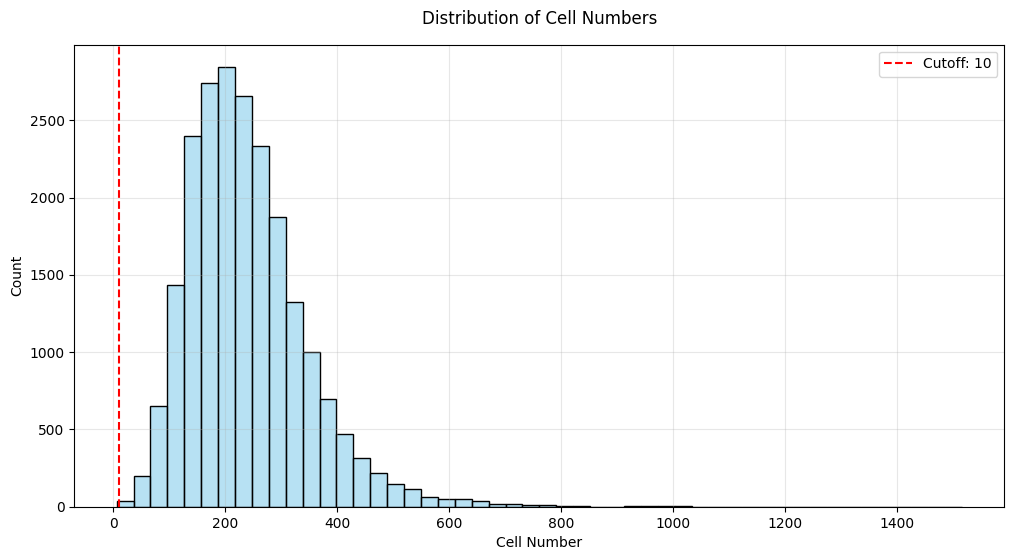

In [5]:
for cell_class, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    channel_combo = CHANNEL_COMBOS[0]
    aggregated_data_path = (
        ROOT_FP
        / "aggregate"
        / "tsvs"
        / get_filename(
            {"cell_class": cell_class, "channel_combo": channel_combo},
            "aggregated",
            "tsv",
        )
    )
    aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

    # show cell count distribution
    print(f"Cell count distribution for: {cell_class}")
    plot_cell_histogram(aggregated_data, min_cell_cutoff, PERTURBATION_NAME_COL)
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Benchmark Generation

- `STRING_PAIR_BENCHMARK_FP`: Path to save and access STRING pair benchmark.
- `CORUM_GROUP_BENCHMARK_FP`: Path to save and access CORUM group benchmark.
- `KEGG_GROUP_BENCHMARK_FP`: Path to save and access KEGG group benchmark.

**Note**: We use the following benchmark schemas:
- Pair Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `pair` column with a pair ID. Used to benchmark known pair relationships in generated cluster.
- Group Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `group` column with a group ID. Used to benchmark known group relationships in generated cluster, where a group represents genes involved in a pathway, protein complex, etc.

In [6]:
UNIPROT_DATA_FP = "config/benchmark_clusters/uniprot_data.tsv"
STRING_PAIR_BENCHMARK_FP = "config/benchmark_clusters/string_pair_benchmark.tsv"
CORUM_GROUP_BENCHMARK_FP = "config/benchmark_clusters/corum_group_benchmark.tsv"
KEGG_GROUP_BENCHMARK_FP = "config/benchmark_clusters/kegg_group_benchmark.tsv"

In [7]:
Path(STRING_PAIR_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)

uniprot_data = get_uniprot_data()
uniprot_data.to_csv(UNIPROT_DATA_FP, sep="\t", index=False)
uniprot_data = pd.read_csv(UNIPROT_DATA_FP, sep="\t")
display(uniprot_data)

string_pair_benchmark = generate_string_pair_benchmark(
    aggregated_data, uniprot_data, "gene_symbol_0"
)
string_pair_benchmark.to_csv(STRING_PAIR_BENCHMARK_FP, sep="\t", index=False)
string_pair_benchmark = pd.read_csv(STRING_PAIR_BENCHMARK_FP, sep="\t")
display(string_pair_benchmark)

corum_group_benchmark = generate_corum_group_benchmark()
corum_group_benchmark.to_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t", index=False)
corum_group_benchmark = pd.read_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t")
display(corum_group_benchmark)

kegg_group_benchmark = generate_msigdb_group_benchmark()
kegg_group_benchmark.to_csv(KEGG_GROUP_BENCHMARK_FP, sep="\t", index=False)
kegg_group_benchmark = pd.read_csv(KEGG_GROUP_BENCHMARK_FP, sep="\t")
display(kegg_group_benchmark)

Fetching UniProt data...
Completed. Total entries: 20460


,entry,gene_names,function,kegg,complexportal,string,link
0,A0A0C5B5G6,MT-RNR1,Regulates insulin sensitivity and metabolic ho...,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/A0A0C5B5G6/e...
1,A0A1B0GTW7,CIROP LMLN2,Putative metalloproteinase that plays a role i...,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/A0A1B0GTW7/e...
2,A0JNW5,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,Tube-forming lipid transport protein which med...,hsa:23074;,NaN,9606.ENSP00000279907;,https://www.uniprot.org/uniprotkb/A0JNW5/entry
3,A0JP26,POTEB3,NaN,hsa:102724631;,NaN,9606.ENSP00000483103;,https://www.uniprot.org/uniprotkb/A0JP26/entry
4,A0PK11,CLRN2,Plays a key role to hearing function. Required...,hsa:645104;,NaN,9606.ENSP00000424711;,https://www.uniprot.org/uniprotkb/A0PK11/entry
...,...,...,...,...,...,...,...
20455,Q9H2U6,LINC00597 C15orf5,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9H2U6/entry
20456,Q9H379,PRO3102,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9H379/entry
20457,Q9P1C3,PRO2829,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9P1C3/entry
20458,Q9UFV3,NaN,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9UFV3/entry


Fetching STRING data...
Completed. Total interactions: 117118


,gene_name_variants,pair,gene_name
0,ARF5,1,ARF5
1,RAB11FIP3 ARFO1 KIAA0665,1,RAB11FIP3
2,M6PR MPR46 MPRD,2,M6PR
3,GGA3 KIAA0154,2,GGA3
4,M6PR MPR46 MPRD,3,M6PR
...,...,...,...
225791,LDB1 CLIM2,117116,LDB1
225792,RFXANK ANKRA1 RFXB,117117,RFXANK
225793,RFX7 RFXDC2,117117,RFX7
225794,RFX7 RFXDC2,117118,RFX7


Fetching CORUM data...


/home/matteodibernardo/miniconda3/envs/brieflow_whitney/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mips.helmholtz-muenchen.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Completed. Total complexes: 5513


,gene_name,group
0,BCL6,BCL6-HDAC4 complex
1,HDAC4,BCL6-HDAC4 complex
2,BCL6,BCL6-HDAC5 complex
3,HDAC5,BCL6-HDAC5 complex
4,BCL6,BCL6-HDAC7 complex
...,...,...
18669,LTK,LTK-IGF1R complex
18670,CD19,CD19-LYN complex
18671,LYN,CD19-LYN complex
18672,CD19,CD19-LCK complex


,gene_name,group
0,ACTB,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
1,ACTG1,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
2,ACTR2,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
3,ACTR3,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
4,ARPC1A,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
...,...,...
9657,LEF1,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9658,MYC,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9659,TCF7,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9660,TCF7L1,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...


## <font color='red'>SET PARAMETERS</font>

### Test Dataset

- `TEST_CELL_CLASS`: Cell class to test clustering on. Usually `all` or cell class of interest.
- `TEST_CHANNEL_COMBO`: Cell class to test clustering on. Usually `all` or cell class of interest.

### Phate/Leiden Clustering

- `PHATE_DISTANCE_METRIC`: Distance metric used by phate during dimensionality reduction. Can be `euclidean` or `cosine`, `cosine` is recommended. Check out this [blog post](https://cmry.github.io/notes/euclidean-v-cosine) for more insight on how to choose a clustering metric.
- `PERTURBATION_AUC_THRESHOLD`: AUC value used to filter out perturbations. Higher AUC value means more selective, usually `0.6`. Can be left as `None` for no filtering.
- `TEST_LEIDEN_RESOLUTIONS`: Resolutions for Leiden clustering. Higher means more clusters (and therefore less genes per cluster). Should be a list of numbers. We recommend `[0.1, 1, 5, 7, 9, 11, 13, 15, 20, 100]`. 

**Notes**: 
- Every resolution takes about 1 minute to generate a cluster for.
- `evaluate_resolution` automatically filters benchmarks to only include genes that we have in the perturbations column.

In [17]:
TEST_CELL_CLASS = "all"
TEST_CHANNEL_COMBO = 'Hoescht_COX4_AGP_ConA'

PHATE_DISTANCE_METRIC = "cosine"
PERTURBATION_AUC_THRESHOLD = None
TEST_LEIDEN_RESOLUTIONS = [1, 5, 10, 20, 30, 40, 50]

CONTROL_KEY = config["aggregate"]["control_key"]

In [18]:
aggregated_data_path = (
    ROOT_FP
    / "aggregate"
    / "tsvs"
    / get_filename(
        {"cell_class": TEST_CELL_CLASS, "channel_combo": TEST_CHANNEL_COMBO},
        "aggregated",
        "tsv",
    )
)
aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

aggregated_data

,gene_symbol_0,cell_count,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,...,PC_784,PC_785,PC_786,PC_787,PC_788,PC_789,PC_790,PC_791,PC_792,PC_793
0,ENSG00000267618,1517,0.089050,0.096764,0.002066,0.079658,-0.151828,0.036567,0.110804,0.113198,...,-0.007162,-0.001129,0.027337,-0.027847,-0.005460,0.006130,-0.034626,-0.041597,0.008078,0.018646
1,HES3,1197,0.096368,0.093435,0.000268,0.113548,-0.145178,0.052944,0.150044,0.136704,...,-0.008519,-0.011317,0.020154,-0.003605,-0.004511,0.015291,0.002758,0.002976,-0.001144,-0.001503
2,nontargeting_intergenic_CTGCACTTTAGG,1129,0.078877,0.080436,0.022759,0.106465,-0.175530,0.050352,0.052863,0.090556,...,0.013302,-0.017206,0.010196,-0.020459,-0.004166,0.002544,-0.016978,-0.026831,0.036571,0.021789
3,nontargeting_or_AAACCAAACCCA,1079,0.097198,0.052800,0.013595,0.109093,-0.150044,0.025645,0.134454,0.099467,...,0.021535,-0.014957,0.006846,-0.029821,0.013404,-0.010578,0.020660,-0.029470,-0.015638,0.007659
4,ING3,1036,0.100021,0.087239,-0.056925,0.095484,-0.250678,0.048021,0.025205,0.119452,...,0.004208,0.009263,-0.016151,-0.029153,-0.010647,-0.018398,0.011298,0.046277,-0.009487,-0.029321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21727,nontargeting_intergenic_GTCGGCTACGCT,22,0.309985,0.086849,-0.148317,0.022905,-0.182813,0.016314,0.005702,0.159102,...,-0.079771,-0.199183,0.051733,0.137580,0.028074,0.090730,0.119437,-0.064776,-0.023375,0.033759
21728,nontargeting_intergenic_GACGTCGAAGCA,19,0.371101,0.076992,-0.110378,0.147640,-0.387496,-0.070485,-0.085332,0.078741,...,0.014067,-0.155948,0.015544,-0.031691,0.043029,0.040984,0.254068,0.077854,-0.172834,-0.218449
21729,nontargeting_intergenic_GACATTCTGCGC,14,0.069062,-0.023746,0.042558,-0.012041,0.145024,0.126518,0.442887,0.235372,...,-0.083448,0.076827,-0.005615,0.107159,-0.174572,-0.094836,-0.029436,0.162309,0.126898,-0.216073
21730,nontargeting_intergenic_CGTTCAGAGTGC,8,0.196662,-0.106198,-0.308111,0.143494,-0.118473,-0.092574,-0.118682,0.309348,...,-0.168104,0.037585,-0.135414,-0.032598,0.147703,0.062270,-0.669556,0.040999,-0.343713,-0.158075


In [19]:
aggregated_data_path = (
    ROOT_FP
    / "aggregate"
    / "tsvs"
    / get_filename(
        {"cell_class": TEST_CELL_CLASS, "channel_combo": TEST_CHANNEL_COMBO},
        "aggregated",
        "tsv",
    )
)
aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

# create baseline data by shuffling columns independently
shuffled_aggregated_data = aggregated_data.copy()
feature_start_idx = shuffled_aggregated_data.columns.get_loc("PC_0")
feature_cols = shuffled_aggregated_data.columns[feature_start_idx:]
for col in feature_cols:
    shuffled_aggregated_data[col] = np.random.permutation(
        shuffled_aggregated_data[col].values
    )

# Run the benchmark analysis with the CORUM clusters
group_benchmarks = {
    "CORUM": corum_group_benchmark,
}

# Run the resolution thresholding analysis
results_df, thresholding_fig = evaluate_resolution(
    aggregated_data,
    PHATE_DISTANCE_METRIC,
    TEST_LEIDEN_RESOLUTIONS,
    group_benchmarks,
    PERTURBATION_NAME_COL,
    CONTROL_KEY,
)

# Display the figure
plt.figure(thresholding_fig.number)
plt.show()

Creating clusters for resolution: 1
Creating clusters for resolution: 5


: 

In [16]:
results_df

,resolution,num_clusters,precision,recall,f1_score,benchmark
0,10,782,0.105639,0.140315,0.120532,CORUM
1,11,836,0.113712,0.140869,0.125842,CORUM
2,12,879,0.120318,0.139342,0.129133,CORUM
3,13,949,0.120287,0.141175,0.129896,CORUM
4,14,985,0.126814,0.137780,0.132070,CORUM
5,15,1039,0.131698,0.136730,0.134167,CORUM
6,16,1089,0.142780,0.135017,0.138790,CORUM
7,17,1115,0.139175,0.128126,0.133422,CORUM
8,18,1174,0.144022,0.129651,0.136459,CORUM
9,19,1205,0.141799,0.123357,0.131936,CORUM


## <font color='red'>SET PARAMETERS</font>

### Phate/Leiden Clustering

- `CLUSTER_COMBO_FP`: Location of cluster combinations dataframe.
- `FINAL_LEIDEN_RESOLUTIONS`: Final list of resolutions for Leiden clustering. The snakmake cluster module will create and benchmark clusters for each of these resolutions. For the rest of the cluster testing in this notebook, we will show one example of this cluster generation and benchmarking (see below).

In [ ]:
CLUSTER_COMBO_FP = "config/cluster_combo.tsv"
FINAL_LEIDEN_RESOLUTIONS = None

In [ ]:
# Load aggregate wildcard combos
AGGREGATE_COMBO_FP = Path(config["aggregate"]["aggregate_combo_fp"])
aggregate_wildcard_combos = pd.read_csv(AGGREGATE_COMBO_FP, sep="\t")

# Generate cluster wildcard combos
cluster_wildcard_combos = aggregate_wildcard_combos[
    ["cell_class", "channel_combo"]
].drop_duplicates()
cluster_wildcard_combos["leiden_resolution"] = [FINAL_LEIDEN_RESOLUTIONS] * len(
    cluster_wildcard_combos
)
cluster_wildcard_combos = cluster_wildcard_combos.explode(
    "leiden_resolution", ignore_index=True
)

# Save aggregate wildcard combos
cluster_wildcard_combos.to_csv(CLUSTER_COMBO_FP, sep="\t", index=False)

print("Cluster wildcard combos:")
cluster_wildcard_combos

## <font color='red'>SET PARAMETERS</font>

### Cluster Generation/Benchmarking Test

- `TEST_LEIDEN_RESOLUTION`: Resolution for testing Leiden cluster creation and evaluation within this notebook. Each leiden resolution listed in `LEIDEN_RESOLUTIONS` above will be used during snakemake run to generate separate clusterings (see above).

In [ ]:
TEST_LEIDEN_RESOLUTION = None

In [ ]:
phate_leiden_clustering = phate_leiden_pipeline(
    aggregated_data,
    TEST_LEIDEN_RESOLUTION,
    PHATE_DISTANCE_METRIC,
)
uniprot_data["gene_name"] = uniprot_data["gene_names"].str.split().str[0]
uniprot_data = uniprot_data.drop_duplicates("gene_name", keep="first")
uniprot_subset = uniprot_data[["gene_name", "entry", "function", "link"]].rename(
    columns={
        "entry": "uniprot_entry",
        "function": "uniprot_function",
        "link": "uniprot_link",
    }
)
phate_leiden_clustering = phate_leiden_clustering.merge(
    uniprot_subset, how="left", left_on="gene_symbol_0", right_on="gene_name"
).drop(columns="gene_name")
display(phate_leiden_clustering)

cluster_size_fig = plot_cluster_sizes(phate_leiden_clustering)
plt.show()

clusters_fig = plot_phate_leiden_clusters(
    phate_leiden_clustering, PERTURBATION_NAME_COL, CONTROL_KEY
)
plt.show()

In [ ]:
phate_leiden_clustering_shuffled = phate_leiden_pipeline(
    shuffled_aggregated_data,
    TEST_LEIDEN_RESOLUTION,
    PHATE_DISTANCE_METRIC,
)

cluster_datasets = {
    "Real": phate_leiden_clustering,
    "Shuffled": phate_leiden_clustering_shuffled,
}

pair_recall_benchmarks = {
    "STRING": string_pair_benchmark,
}

group_enrichment_benchmarks = {
    "CORUM": filter_complexes(
        corum_group_benchmark,
        phate_leiden_clustering,
        perturbation_col_name=PERTURBATION_NAME_COL,
        control_key=CONTROL_KEY,
    ),
    "KEGG": filter_complexes(
        kegg_group_benchmark,
        phate_leiden_clustering,
        perturbation_col_name=PERTURBATION_NAME_COL,
        control_key=CONTROL_KEY,
    ),
}

(
    integrated_results,
    combined_tables,
    global_metrics,
    pie_charts,
    cluster_enrichment_plots,
) = run_benchmark_analysis(
    cluster_datasets,
    string_pair_benchmark,
    corum_group_benchmark,
    kegg_group_benchmark,
    PERTURBATION_NAME_COL,
    CONTROL_KEY,
)

## Add cluster parameters to config file

In [ ]:
# Add cluster section
config["cluster"] = {
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "leiden_resolutions": FINAL_LEIDEN_RESOLUTIONS,
    "phate_distance_metric": PHATE_DISTANCE_METRIC,
    "cluster_combo_fp": CLUSTER_COMBO_FP,
    "uniprot_data_fp": UNIPROT_DATA_FP,
    "string_pair_benchmark_fp": STRING_PAIR_BENCHMARK_FP,
    "corum_group_benchmark_fp": CORUM_GROUP_BENCHMARK_FP,
    "kegg_group_benchmark_fp": KEGG_GROUP_BENCHMARK_FP,
    "perturbation_auc_threshold": PERTURBATION_AUC_THRESHOLD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)